# M2 - Web of Science

### Table of Contents 

0. **Data Import and Cleaning**
1. **EDA and Network Analysis**
2. **Semantic Search**
3. **Supervised Learning**

This project is based on data from the Web of Science HDLTex dataset (1), which is a dataset used for hierarchical text classification. The dataset is used in the paper [HDLTex: Hierarchical Deep Learning for Text Classification](https://arxiv.org/abs/1709.08267).

The dataset consists of abstracts of papers within 7 domains and 134 categories. 

(1): https://github.com/kk7nc/HDLTex

## 0 - Data Import and Cleaning

The code in this section does the following: 
* Imports the necessary libraries for the project.
* Imports the data.
* Cleans the data (no NLP preprocessing, just basic cleaning)

In [489]:
# Importing the necessary libraries.

# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import string
import re
import warnings

# 1 - EDA and Network Analysis Specific
from wordcloud import WordCloud
import networkx as nx
import nxviz as nv

# 2 - Supervised Learning Specific
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import naive_bayes
import timeit
from sklearn.model_selection import train_test_split
import logging
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import xgboost as xgb

# 3 - Semantic Search Specific
from sklearn.metrics.pairwise import cosine_similarity

sns.set()
sns.set_palette('Blues')

warnings.filterwarnings("ignore")

In [80]:
# Reading the data from the parquet file.
df = pd.read_parquet('wos_data.parquet')

In [81]:
# Creating a column map, to ensure formatting of the column names. 
column_map = {
    'Y1': 'domain_label',
    'Y2': 'area_label',
    'Y' : 'domain_area_label',
    'Domain': 'domain',
    'area': 'area',
    'keywords': 'keywords',
    'Abstract': 'abstract'
}

In [82]:
# Renaming the columns according to the column map
df = df.rename(columns=column_map)

In [83]:
# Stripping the domain, area, keywords and abstract columns from leading and trailing whitespace
df['domain'] = [str(i).strip() for i in df['domain']]
df['area'] = [str(i).strip() for i in df['area']]
df['keywords'] = [str(i).strip() for i in df['keywords']]
df['abstract'] = [str(i).strip() for i in df['abstract']]

In [84]:
# Creating an ID column.
df['ID'] = [int(i) for i in range(len(df))]

In [85]:
# Splitting the keywords into a list with keywords
df['keywords'] = [keyword for keyword in df['keywords'].str.split(";")]

In [523]:
df.head()

,domain_label,area_label,domain_area_label,domain,area,keywords,abstract,ID
0,0,12,12,CS,Symbolic computation,"[(2+1)-dimensional non-linear optical waves, ...",(2 + 1)-dimensional non-linear optical waves t...,0
1,5,2,74,Medical,Alzheimer's Disease,"[Aging, Tau, Amyloid, PET, Alzheimer's dis...",(beta-amyloid (A beta) and tau pathology becom...,1
2,4,7,68,Civil,Green Building,"[LED lighting system, PV system, Distributed...",(D)ecreasing of energy consumption and environ...,2
3,1,10,26,ECE,Electric motor,"[NdFeB magnets, Electric motor, Electric veh...",(Hybrid) electric vehicles are assumed to play...,3
4,5,43,115,Medical,Parkinson's Disease,"[Parkinson's disease, dyskinesia, adenosine ...","(L)-3,4-Dihydroxyphenylalanine ((L)-DOPA) rema...",4


In [524]:
df.shape

(46985, 8)

## 1 - EDA and Network Analysis

The following section will do some basic EDA and Network Analysis. 

### 1.1 - EDA

The EDA will begin with an overview of the number of papers in the different domains. Then we will look at the most common words in all of the subjects using word clouds. 

In [26]:
# Computing the number of papers in each domain
df['domain'].value_counts()

Medical         14625
Psychology       7142
CS               6514
biochemistry     5687
ECE              5483
Civil            4237
MAE              3297
Name: domain, dtype: int64

<AxesSubplot:xlabel='domain', ylabel='count'>

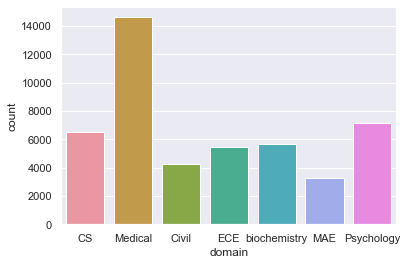

In [34]:
# Creating a countplot of papers in the different domains
sns.countplot(x=df['domain'])

As can be seen above the papers that we have in our dataset is somewhat equally weighted around 5000 with "Medical" being an outlier with over 14000 examples. However, the dataset seems to be weighted fine for out tasks. 

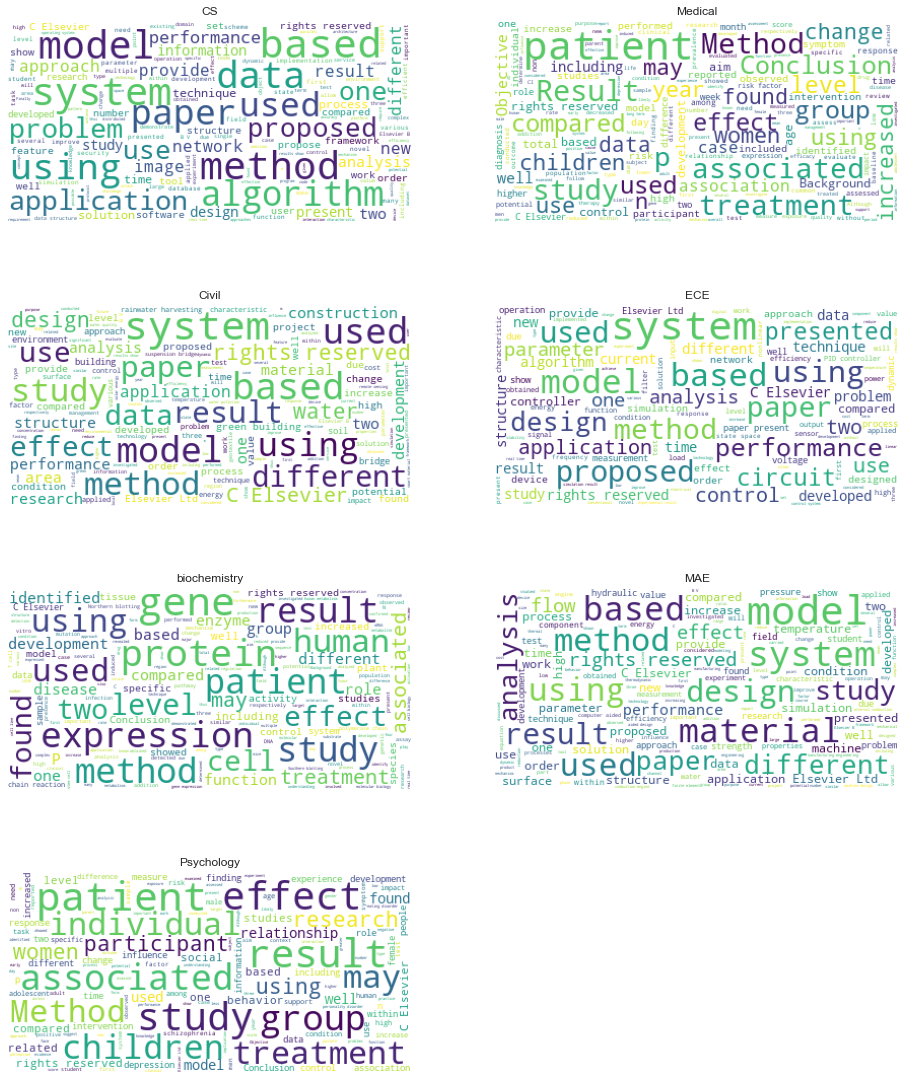

In [35]:
domains = ['CS', 'Medical', 'Civil', 'ECE', 'biochemistry', 'MAE', 'Psychology']

def topicWordCloud(data, topic_number):
    topic = " ".join(df[df['domain'] == domains[topic_number]]['abstract'])
    wordcloud = WordCloud(background_color="white",
                          max_words=1000,
                          max_font_size=40,
                          relative_scaling=.5,
                          random_state=42).generate(topic)
    return wordcloud


fig = plt.figure(figsize=(16,20))
for i in range(len(domains)):
    ax = fig.add_subplot(4,2,i+1)
    ax.title.set_text(domains[i])
    wordcloud = topicWordCloud(df, i)

    ax.imshow(wordcloud)
    ax.axis('off')

The wordclouds above give us an idea about the words contained by the abstracts in the different domains. We can see that there are some clear similarities, such as "children" being one of the most common words in Psychology and "algorithm" being one of the most common words in Computer Science. There are some words that are common in most domains though, like "result", "methoid" and "model.

### 1.2 - Network Analysis

In [95]:
# Creating a list of all keywords in the dataframe
all_keywords = [str(item).strip() for sublist in df['keywords'] for item in sublist]
all_keywords = list(dict.fromkeys(all_keywords))
all_keywords[:5]

['(2+1)-dimensional non-linear optical waves',
 'erbium-doped optical fibre',
 'symbolic computation',
 'soliton solution',
 'soliton interaction']

In [97]:
# Viewing the number of unique keywords
len(all_keywords)

133591

In [98]:
# We create a pandas series with one row for each keyword in each paper.
s = df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)

In [103]:
# We name the series 'keyword'
s.name = 'keyword'

In [104]:
# We join the new series 's' on the dataframe and create a new dataframe with keywords
df_keyword = df.drop('keywords', axis=1).join(s)

In [126]:
# We drop the unwanted columns.
df_keyword = df_keyword.drop(columns=['domain_label', 'area_label', 'domain_area_label', 'abstract', 'area', 'domain'])

In [127]:
# We create a dataframe of combinations where two papers have the same 
edges = pd.merge(df_keyword, df_keyword, how='inner', on='keyword')

In [132]:
# We remove self-directed loops in our edgelist
edges = combinations[combinations['ID_x'] != combinations['ID_y']]

In [139]:
# We rearrange the columns and now we have an edgelist
edges = edges[['ID_x', 'ID_y', 'keyword']]
edges

,ID_x,ID_y,keyword
3,0,760,symbolic computation
4,0,3749,symbolic computation
5,0,9919,symbolic computation
6,0,13094,symbolic computation
7,0,16686,symbolic computation
...,...,...,...
2436827,46718,46717,localized excitations
2437324,46920,46921,xylem anatomy
2437325,46921,46920,xylem anatomy
2437434,46965,46967,microcephaly


In [140]:
# We create a dataframe to hold the nodes
nodes = pd.DataFrame({'ID': df['ID'],
                      'domain': df['domain'], 
                      'area': df['area']})
nodes

,ID,domain,area
0,0,CS,Symbolic computation
1,1,Medical,Alzheimer's Disease
2,2,Civil,Green Building
3,3,ECE,Electric motor
4,4,Medical,Parkinson's Disease
...,...,...,...
46980,46980,Medical,Sports Injuries
46981,46981,CS,Data structures
46982,46982,Medical,Cancer
46983,46983,CS,Distributed computing


In [144]:
# We create a NetworkX object
G = nx.from_pandas_edgelist(edges, 'ID_x', 'ID_y', edge_attr=True, create_using=nx.Graph)

In [146]:
# We set the node attributes:
nx.set_node_attributes(G, nodes['domain'], 'domain')
nx.set_node_attributes(G, nodes['area'], 'area')

We have now defined a network with edges between all papers that share keywords. We can use this to find the most central papers in our dataframe. For this we can use degree centrality, which is computed as follows: 
$$c_j^{dgr} = \sum_{j=1}^n e_{ij} \text{ where: } i \neq j$$

where $e_{ij}$ is the 1 if an edge is present between $i$ and $j$ and 0 otherwise.

In [164]:
# Computing the degree centrality for the network:
deg_cent_G = nx.degree_centrality(G)
nx.set_node_attributes(G, deg_cent_G, name='Degree Centrality')

In [169]:
# Finding the paper with the highest degree centrality
print("The most central paper in the network is within: \n",
f"Domain: {df.loc[max(deg_cent_G, key=deg_cent_G.get), 'domain']}\n",
f"Area: {df.loc[max(deg_cent_G, key=deg_cent_G.get), 'area']}\n",
f"Keywords: {df.loc[max(deg_cent_G, key=deg_cent_G.get), 'keywords']}")

The most central paper in the network is within: 
 Domain: Medical
 Area: Irritable Bowel Syndrome
 Keywords: ['Mood disorders', ' Obesity', ' Depression', ' Diabetes', ' Microbiota', ' Chronic fatigue syndrome', ' Inflammation', ' Psychiatry', ' Irritable bowel syndrome', ' Oxidative stress']


Due to the way we have constructed our network with edges between papers with the same keywords, the degree centrality does not give us a great idea of the most important paper in our network. A high degree centrality in this case would be influenced by having a large number of keywords, and that the keywords are often used by other papers. It does however say something about the importance of the keywords, as the keywords in the node with highest degree centrality are probably popular research areas.

Another centrality measure is betweenness centrality, which measures if a node lies on many shortest paths. Thus, this might be of more interest to us, as if a paper has a high betweenness centrality we might assume that it is an important interdisciplinary paper. 

In [175]:
# Testing how long betweenness centrality takes to run on the following random graphs:
# 20 vertices, 50 edges
# 200 vertices, 500 edges
# 2000 vertices, 5000 edges
import time
for n in [20,200,2000]:
    G_1 =nx.fast_gnp_random_graph(n, 5./n)
    current_time = time.time()
    a=nx.betweenness_centrality(G_1)
    print (time.time()-current_time)


0.0010118484497070312
0.08416414260864258
14.598091125488281


As 5000 edges is approximately 0.23 % of 2200000 edges, calculating the betweenness centrality for our network would take approximately two hours. Thus, due to time constraints we look at papers with the highest betweenness centrality in the domain Computer Science (which is also the most interesting for us).

In [179]:
# Computing the betweenness centrality for the network:
cs_nodes = [n for n,v in G.nodes(data=True) if v['domain'] == 'CS']  
H = G.subgraph(cs_nodes)

bet_cent_H = nx.betweenness_centrality(H)
nx.set_node_attributes(H, bet_cent_H, name='Betweenness Centrality')

In [180]:
# Finding the paper with the highest betweenness centrality
print("The most central paper in the network in terms of betweenness centrality is within: \n",
f"Domain: {df.loc[max(bet_cent_H, key=bet_cent_H.get), 'domain']}\n",
f"Area: {df.loc[max(bet_cent_H, key=bet_cent_H.get), 'area']}\n",
f"Keywords: {df.loc[max(bet_cent_H, key=bet_cent_H.get), 'keywords']}")

The most central paper in the network in terms of betweenness centrality is within: 
 Domain: CS
 Area: Machine learning
 Keywords: ['K-Means', ' Morphological reconstruction', ' Mathematical morphology', ' GPU', ' CUDA', ' Machine learning', ' Unsupervised learning', ' Image segmentation', ' Noise removal', ' Clusterization', ' Clustering', ' Parallelism']


Now the most central paper in terms of betweenness centrality is within Machine Learning. The betweenness centrality here shows that this paper is the one that lies on the most shortest paths in the Computer Science domain. 

Using network analysis we can also compute network level measurs for our entire network. We can use density to measure the degree of which our network is connected. We can use transitivity to determine whether our network tends to be locally clustered. We can use diameter of the network to determine how spaced out the network is through finding the longest shortest path between two papers. The mean distance can be used to get an understanding of the average length there is between two random papers in our dataset.

In [505]:
# Computing the density of our network
print(f"The density of our network G is: {nx.density(G)}")

The density of our network G is: 0.0011653070405511913


From the density we can tell that the graph is not very connected. This would make sense, as most papers in fx Medicine does not share any keywords with any papers in Computer Science. Thus, establishing our network based on related keywords, yields a very sparse network. Our intuition tells us that the network is very sparse, but due to the fact that we have papers from 7 domains and 134 areas, we might expect papers within these areas to be in many connected triplets. Let's test our intuition by computing the transitivity of the networr

In [525]:
# Computing the transitivity of our network
print(f"The transitivity of our network G is: {nx.transitivity(G)}")

The transitivity of our network G is: 0.5463757366484999


Since the transitivity of a network lies between 0 and 1, we have quite a high transitivity, thus supporting our intuition of a high clustering. Although we expected that our network has many closed triplets, we might also have the intuition that the network is very spaced out. We can check this by computing the mean distance and diameter if our graph is connected, meaning that there is a path between every node in our graph. 

In [514]:
# Checking whether or not our graph is connected.
nx.is_connected(G)

False

Since our graph is not connected we cannot compute the mean distance and the diameter of our graph.

The network analysis gives us some methods to measure various things about the entire network of papers. The goal of the network analysis has been to get some intuition on how our dataset of papers is structured.

How can we use this?

We now know that the network is not connected, meaning there might not be a way to traverse the graph from a node in medicine to a node in machine learning. The graph is to an extent locally clustered, this is great for our next task, as this might mean that there is a high similarity between papers in the same areas, and less so between areas. The density of the network is very low, meaning that the papers in our network is usually not very connected. This might be an advantage, as our supervised model is going to classify papers from different areas, and if all the papers were very alike, the models would have a hard time differentiating papers from diffferent areas.

## 2 - Supervised Learning

The task of the supervised learning in this section will be focused on classifying the domain label of the 

We are going to train various supervised models on our training dataset. The models we are going to be using are:
* Logistic Regression
* Naive Bayes
* LSTM Neural Network

We are of course aiming for the highest accuracy possible, and as it is a classification problem with discrete classes, we use accuracy as our metric.

The performance of the models is of course important, but even more important is how the preprocessing of the text data is influencing the performance. Thus, we will run our models with a variety of different preprocessing techniques. These include, but are not limited to:
* Stemming and Lemmatization
* Stop Word Removal
* CountVectorization
* TfidfVectorization
* Word2Vec

First we will split our dataset into train and test, to ensure that we are able to evaluate the models on unseen data in the end.

In [185]:
# Creating our training and testing data.
X_train, X_test, y_train, y_test = train_test_split(
    df['abstract'], df['domain_label'], random_state=42)

***CountVectorized Logistic Regression***

The first model we use is the Logistic Regression. Here the only preprocessing we've done is CountVectorizing the text. The `CountVectorizer` works by first defining a corpus from all the texts, where every word from the texts are given an index in the corpus. Each example of our dataset is then converted to a vector containing counts of every word in the text. Thus, by CountVectorizing our entire dataset we get a sparse matrix with one row for each example and one column for each word in the corpus. 


In [188]:

from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import naive_bayes
import timeit

def log_reg(X_train, y_train, vectorizer="CountVectorizer"):
    start = timeit.default_timer()
    # Defining the dataframe:
    df = pd.DataFrame({'Text': X_train,
                       'Target': y_train})

    # Defining dataframe to hold results:
    
    column_names = ['Model', 'Fold', 'Accuracy', 'Preprocessing']

    results_df = pd.DataFrame(columns=column_names)

    # Creating a new column to control the folds.
    df['kfold'] = -1

    # Randomizing the rows of the data to ensure a random sample.
    df = df.sample(frac=1).reset_index(drop=True)

    # Storing the targets in the y variable
    y = df['Target'].values

    # Initiating the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)

    # Filling the kfold column with values for the folds
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f

    # Now we train and test on each of the 5 folds.
    for fold_ in range(5):
        # We create a temporary dataframe for train and test.
        train_df = df[df['kfold'] != fold_].reset_index(drop=True)
        test_df = df[df['kfold'] == fold_].reset_index(drop=True)

        # Initializing the countvectorizer with NLTK's word_tokenize
        if vectorizer == "CountVectorizer":
            vectorize = CountVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None
            )

        elif vectorizer == "TfidfVectorizer":
            vectorize = TfidfVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None
            )

        if vectorizer is not None:
            
        # Fitting the count_vec on the training data text:
            vectorize.fit(train_df['Text'])

            # Transforming the trianing and validation data
            xtrain = vectorize.transform(train_df['Text'])
            xtest = vectorize.transform(test_df['Text'])
        
        if vectorizer is None: 
            xtrain = train_df['Text']
            xtest = test_df['Text']

        # Initializing the Logistic Regression model
        model = linear_model.LogisticRegression()

        # Fitting the model on the training data and the classes
        model.fit(xtrain, train_df['Target'])

        # Computing predicitions for the test data. 
        preds = model.predict(xtest)

        # Computing the accuracy
        accuracy = metrics.accuracy_score(test_df['Target'], preds)
        results_df = results_df.append({'Model': 'Logistic Regression',
                                      'Fold': fold_,
                                      'Accuracy': accuracy,
                                      'Preprocessing':  vectorizer + ' and WordToken'},
                                       ignore_index=True)
        
        print(f"Fold {fold_}")
        print(f"Accuracy = {accuracy}")
        print("")
    stop = timeit.default_timer()
    print("TIME: ", stop - start)
    results_df['Total Time for All Folds'] = stop - start
    return results_df

In [189]:
lr_cv_raw = log_reg(X_train, y_train)

Fold 0
Accuracy = 0.8098751418842225

Fold 1
Accuracy = 0.8243473325766175

Fold 2
Accuracy = 0.8176787741203179

Fold 3
Accuracy = 0.8141052930324961

Fold 4
Accuracy = 0.8246062154108131

TIME:  508.9023389000031


As can be seen above the average accuracy of the Logistic Regression model is around 81.5 %, and it took ~500 sec to run. 

The logistic regression on CountVectorized with ~80 % accuracy is our new benchmark. Thus, it is this accuracy we will try to improve.

Now, we will run a Multinomial Naive Bayes model on CountVectorized data.

In [192]:
def mn_bayes(X_train, y_train, vectorizer="CountVectorizer"):
    start = timeit.default_timer()
    # Defining the dataframe:
    df = pd.DataFrame({'Text': X_train,
                       'Target': y_train})

    # Defining dataframe to hold results:
    
    column_names = ['Model', 'Fold', 'Accuracy', 'Preprocessing']

    results_df = pd.DataFrame(columns=column_names)


    # Creating a new column to control the folds.
    df['kfold'] = -1

    # Randomizing the rows of the data to ensure a random sample.
    df = df.sample(frac=1).reset_index(drop=True)

    # Storing the targets in the y variable
    y = df['Target'].values

    print(y.shape)
    # Initiating the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)

    # Filling the kfold column with values for the folds
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f

    # Now we train and test on each of the 5 folds.
    for fold_ in range(5):
        # We create a temporary dataframe for train and test.
        train_df = df[df['kfold'] != fold_].reset_index(drop=True)
        test_df = df[df['kfold'] == fold_].reset_index(drop=True)

        # Initializing the countvectorizer with NLTK's word_tokenize
        if vectorizer == "CountVectorizer":
            vectorize = CountVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None
            )

        elif vectorizer == "TfidfVectorizer":
            vectorize = TfidfVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None
            )


        # Fitting the count_vec on the training data text:
        vectorize.fit(train_df['Text'])

        # Transforming the trianing and validation data
        xtrain = vectorize.transform(train_df['Text'])
        xtest = vectorize.transform(test_df['Text'])

        # Initializing the Logistic Regression model
        model = naive_bayes.MultinomialNB()

        # Fitting the model on the training data and the classes
        model.fit(xtrain, train_df['Target'])

        # Computing predicitions for the test data. 
        preds = model.predict(xtest)

        # Computing the accuracy
        accuracy = metrics.accuracy_score(test_df['Target'], preds)
        results_df = results_df.append({'Model': 'Multinomial Naive Bayes',
                                      'Fold': fold_,
                                      'Accuracy': accuracy,
                                      'Preprocessing':  vectorizer + 'and WordToken'},
                                       ignore_index=True)
        
        print(f"Fold {fold_}")
        print(f"Accuracy = {accuracy}")
        print("")
    stop = timeit.default_timer()
    print("TIME: ", stop - start)
    results_df['Total Time for All Folds'] = stop - start
    return results_df

In [193]:
mnb_raw_cv = mn_bayes(X_train, y_train, vectorizer='CountVectorizer')

(35238,)
Fold 0
Accuracy = 0.7424801362088536

Fold 1
Accuracy = 0.7424801362088536

Fold 2
Accuracy = 0.7475879682179342

Fold 3
Accuracy = 0.7360578969774372

Fold 4
Accuracy = 0.751667376188449

TIME:  382.72664590000204


As can be seen above the Naive Bayes model is performing worse than our Logistic Regression. Thus, it fails to beat the benchmark. However, it is around twice as fast (accounting for the vectorization).

In NLP we often clean the data we are working with. Some of the methods used for cleaning can be removing stopwords, removing punctuation, lemmatizing or stemming the words. Now we will try to clean our X_train data, and see if this improves performance.

In the below cleaning function we are lowercasing the words, removing punctuation, removing stopwords, and lemmatizing the sentences.

The stopwords are moved to cache to improve performance (if just called in the list comp it would take much longer).

In [204]:
nltk.download('stopwords')

def clean_func(text, root):
    # We lowercase the text
    text = text.lower()
    
    # We split and rejoin the text to ensure that the whitespace is equal.
    text = text.split()
    text = " ".join(text)
    
    # We remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    
    # We move stopwords to cache to ensure an efficient run time
    cached_stopwords = stopwords.words('english')
    
    # We tokenize the text and remove stopwords.
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if not word in cached_stopwords]
    
    if root == 'lemma':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    if root == 'stem':
        stemmer = SnowballStemmer()
        tokkens = [stemmer.stem(word) for word in tokens]
    
    result_sentence = " ".join(tokens)
    return result_sentence

[nltk_data] Downloading package stopwords to C:\Users\Sebastian
[nltk_data]     Linde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
# Cleaning text, removing stopwords, stemming words
X_train_clean = X_train.apply(clean_func, root="lemma")

In [206]:
# Let's compare an example from the original X_train to the cleaned X_train
print("Original sentence: \n")
print(X_train[9576])
print(30*"-")
print("Cleaned sentence: \n")
print(X_train_clean[9576])

Original sentence: 

Biological specimens such as cells, tissues and biofluids (urine, blood) contain mixtures of many different biomolecules, all of which contribute to a Raman spectrum at any given point. The separation and identification of pure biochemical components remains one of the biggest challenges in Raman spectroscopy. Multivariate curve resolution, a matrix factorization method, is a powerful, yet flexible, method that can be used with constraints, such as non-negativity, to decompose a complex spectroscopic data matrix into a small number of physically meaningful pure spectral components along with their relative abundances. This paper reviews recent applications of multivariate curve resolution by alternating least squares analysis to Raman spectroscopic and imaging data obtained either in vivo or in vitro from biological and medical samples.
------------------------------
Cleaned sentence: 

biological specimen cell tissue biofluids urine blood contain mixture many diff

As can be seen above, the cleaned sentence is all lowercase, no punctuation, no stop words, and lemmatized. Let's evaluate how this impacts performance. We will only do this on the Logistic Regression, as this is our current benchmark.

In [207]:
lr_clean_cv = log_reg(X_train_clean, y_train)

Fold 0
Accuracy = 0.8188138479001135

Fold 1
Accuracy = 0.8196651532349603

Fold 2
Accuracy = 0.815266742338252

Fold 3
Accuracy = 0.8193557542216546

Fold 4
Accuracy = 0.821910032638002

TIME:  291.4678867000039


So far we've been using the CountVectorizer to vectorize our sentences. Another method is to use a TF-IDF (Term Frequency Inverse Document Frequency) vectorizer. When using TF-IDF vectorizing the values of the words is penalized if they are in many documents. Thus, we again get a sparse matrix with the words of our entire corpus in the columns and the examples in the rows. But now, instead of term frequencies we have the TF-IDF values in each cell the penalizing IDF parameter is calculated as follows: 
$$IDF(w)=\log \frac{N}{n_w}$$
where $N$ is the total number of documents, and $n_w$ is the number of documents containing the word $w$. Thus, if a word is represented in many documents the TF-IDF value will be low and if the word is infrequent the TF-IDF value will be higher. 

Let's see how using the TF-IDF vectorized sentences impacts the performance of our logistic regression model:

In [208]:
# Running Logistic Regression on TfidfVectorized sentences.
lr_clean_tfidf_results = log_reg(X_train_clean, y_train, vectorizer="TfidfVectorizer")

Fold 0
Accuracy = 0.8227866061293984

Fold 1
Accuracy = 0.822360953461975

Fold 2
Accuracy = 0.8229284903518729

Fold 3
Accuracy = 0.8183624237264084

Fold 4
Accuracy = 0.8291471548176529

TIME:  288.563267000005


Using a TF-IDF vectorizer instead of the simple term frequency approach yields a model that is ~2 % better and runs faster. This result will be our new benchmark. This result shows us that the important words are probabbly those words that are not present in all documents. This makes sense, as if a word were present in most documents it would not tell much about the differences between the classes. 

The vectorization done by both the CountVectorizer and the TfidfVectorizer does keep any information about the words, thus all the examples are reduced to vectors in which the only meaning is given by the difference between the vectors in our dataset. In recent years, deep learning have been used to create other vectorization methods. Using a neural networks to learn distributed representations, models like Word2Vec can create word representations in vector spaces. These word embeddings have been shown achieve better results in many use cases than the more traditional vectorization methods such as TF-IDF and Count Vectorization (2).

(2) [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)

We will now first train our own word embeddings and following try to use the fastText word embeddings for our task. First, we will create a new dataframe with cleaned abstracts, but conduct no stemming or lemmatization.

In [233]:
# Creating a list of clean abstracts
clean_abstract = df['abstract'].apply(clean_func, root=None)

In [234]:
# Creating a new dataframe with clean abstracts
df_clean = df.copy()
df_clean['abstract'] = clean_abstract

In [235]:
# Here we define a function to create the embedding dict

def embedding_dict_constructor(
    corpus,
    vector_size=300,
    window=5,
    min_count=3,
    workers=6,
    epochs=10):
    
    """
    param corpus: the corpus of text we are working with.
    param vector_size: the vector size of the word embeddings we are training.
    param window: 
    """

    # logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    w2v = Word2Vec(
        sentences=corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        epochs=epochs)
    
    return w2v

In [236]:
# Creating the embedding dict:
embedding_dict = embedding_dict_constructor(clean_abstract.apply(word_tokenize), epochs=10)

2021-11-01 05:43:43,416 : INFO : collecting all words and their counts
2021-11-01 05:43:43,417 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-01 05:43:43,669 : INFO : PROGRESS: at sentence #10000, processed 1469995 words, keeping 82300 word types
2021-11-01 05:43:43,897 : INFO : PROGRESS: at sentence #20000, processed 2675646 words, keeping 121222 word types
2021-11-01 05:43:44,153 : INFO : PROGRESS: at sentence #30000, processed 4051294 words, keeping 157272 word types
2021-11-01 05:43:44,421 : INFO : PROGRESS: at sentence #40000, processed 5253470 words, keeping 186648 word types
2021-11-01 05:43:44,574 : INFO : collected 203886 word types from a corpus of 6031661 raw words and 46985 sentences
2021-11-01 05:43:44,575 : INFO : Creating a fresh vocabulary
2021-11-01 05:43:44,816 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 72671 unique words (35.64295733890508%% of original 203886, drops 131215)', 'datetime': '2021-11-01T0

2021-11-01 05:44:12,090 : INFO : EPOCH - 4 : training on 6031661 raw words (5834360 effective words) took 6.8s, 856694 effective words/s
2021-11-01 05:44:13,100 : INFO : EPOCH 5 - PROGRESS: at 13.29% examples, 820874 words/s, in_qsize 11, out_qsize 0
2021-11-01 05:44:14,100 : INFO : EPOCH 5 - PROGRESS: at 25.50% examples, 831728 words/s, in_qsize 11, out_qsize 0
2021-11-01 05:44:15,129 : INFO : EPOCH 5 - PROGRESS: at 42.03% examples, 841825 words/s, in_qsize 11, out_qsize 0
2021-11-01 05:44:16,134 : INFO : EPOCH 5 - PROGRESS: at 56.20% examples, 855286 words/s, in_qsize 11, out_qsize 0
2021-11-01 05:44:17,144 : INFO : EPOCH 5 - PROGRESS: at 71.59% examples, 863253 words/s, in_qsize 11, out_qsize 0
2021-11-01 05:44:18,166 : INFO : EPOCH 5 - PROGRESS: at 88.78% examples, 863841 words/s, in_qsize 11, out_qsize 0
2021-11-01 05:44:18,788 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-01 05:44:18,790 : INFO : worker thread finished; awaiting finish of 4 more threa

2021-11-01 05:44:51,496 : INFO : EPOCH - 10 : training on 6031661 raw words (5834335 effective words) took 6.6s, 884043 effective words/s
2021-11-01 05:44:51,497 : INFO : Word2Vec lifecycle event {'msg': 'training on 60316610 raw words (58345038 effective words) took 65.6s, 889367 effective words/s', 'datetime': '2021-11-01T05:44:51.497388', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'train'}
2021-11-01 05:44:51,497 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=72671, vector_size=300, alpha=0.025)', 'datetime': '2021-11-01T05:44:51.497388', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'created'}


Now that we have learned word embeddings for the words in our dataframe, we will convert each abstract to a 300-d vector. We will do this by creating a weighted sum of all the word embeddings in each abstract. The weight to be applied is the TF-IDF value of the words in the abstract.

In [243]:
# To be used in the sentence vectorizer
def dummy_fun(doc):
    return doc

In [225]:
# Creating a function that will return TF-IDF weighted representations of the vectors.
def sentence_vectorizer(
    text,
    embedding_dict):

    """
    This function returns a vectorized embedding for a sentence.
    """

    # We instantiate a TF-IDF object
    tfidf = TfidfVectorizer(vocabulary=embedding_dict.wv.key_to_index.keys(),
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None) 
    
    df_clean_tfidf = tfidf.fit_transform(text)
    

    M = df_clean_tfidf @ embedding_dict.wv.vectors 

    return M


In [240]:
# Creating a TF-IDF weighted abstract embedding.
vect_abstract = sentence_vectorizer(df_clean['abstract'], embedding_dict)

In [241]:
df_vect = pd.DataFrame(vect_abstract.tolist())

In [242]:
df_vect

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.028825,0.947743,-0.127885,0.224387,-0.790205,-1.432304,6.243021,8.583237,1.537752,-0.641734,...,-0.824147,-1.076970,-4.038823,-0.596337,1.460111,-3.654427,5.203317,3.902857,-4.087120,-0.871582
1,0.580874,-0.111994,4.279762,0.723184,1.813632,2.476320,2.300603,1.321843,2.518189,-0.670396,...,-0.997949,1.091669,-0.072179,1.698042,0.329741,-3.180049,1.484806,-2.377011,-1.542828,-2.482585
2,1.693971,0.495867,0.821512,-3.652024,-0.642986,-3.848346,2.848827,1.887691,1.342144,-0.020730,...,0.492683,-1.934355,-0.110547,1.053684,-1.523069,-2.712785,2.174446,1.069610,-2.299349,-2.194207
3,1.797207,1.266080,0.183317,-1.190685,-1.164360,-3.584275,1.436047,1.734884,-0.285041,0.996475,...,0.395129,-0.157365,0.887050,1.305904,-1.835017,-3.665951,3.014021,0.991398,-2.666833,-2.713116
4,2.364040,1.098349,1.503126,0.706198,-0.435341,1.244713,0.020187,-0.243654,-0.344995,-0.284580,...,0.288799,2.464867,1.359372,-0.147534,0.991214,-0.089683,0.811770,-2.657019,1.035727,0.936540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46980,0.192116,-0.033953,1.289780,0.371721,0.951110,-1.401651,1.398166,1.880290,0.590059,-1.378232,...,0.488388,0.753208,1.289896,0.113743,-0.186279,0.841430,0.520480,-0.897598,1.245205,-1.956671
46981,2.014155,-0.342004,-2.325770,-2.888323,-1.696740,-3.059791,3.387107,3.292774,2.841930,2.244312,...,-0.625324,-0.991403,-0.550068,0.296939,-2.056334,-5.488981,1.837805,-0.779606,-1.667957,-1.545992
46982,-0.153978,1.940501,0.336299,-1.003804,-1.892384,-0.472401,3.151902,3.429829,-2.122449,-0.092723,...,0.424466,0.124726,0.139070,0.780352,-2.551452,-1.145102,0.820701,-0.956951,-0.427580,1.301834
46983,0.840964,-0.523306,-0.137962,-4.577865,-1.530478,-0.839382,4.800531,1.340093,2.183543,0.558798,...,0.277678,-1.004331,-1.856743,2.259273,-0.857458,-5.403560,3.785043,0.186935,-2.562672,-3.570175


Now that we have a representation for each abstract, let's try to run a Logistic Regression on the new data.

In [479]:
# Train test split on new df:
# Creating our training and testing data.
X_train_vect, X_test_vect, y_train_vect, y_test_vect = train_test_split(
    df_vect, df['domain_label'], random_state=42)

In [480]:
X_train_vect_np = np.asarray(X_train_vect)
y_train_vect_np = np.asarray(y_train_vect)
X_test_vect_np = np.asarray(X_test_vect)
y_test_vect_np = np.asarray(y_test_vect)

In [481]:
def simple_log_reg(X_train, y_train):
    start = timeit.default_timer()
    
    df = pd.DataFrame(X_train)
    df['target'] = y_train
    
    # Defining dataframe to hold results:
    
    column_names = ['Model', 'Fold', 'Accuracy', 'Preprocessing']

    results_df = pd.DataFrame(columns=column_names)

    # Creating a new column to control the folds.
    df['kfold'] = -1

    # Randomizing the rows of the data to ensure a random sample.
    df = df.sample(frac=1).reset_index(drop=True)

    # Storing the targets in the y variable
    y = df['target'].values
    
    kf = model_selection.StratifiedKFold(n_splits=5)


    for fold_, (t_, v_) in enumerate(kf.split(X=df.iloc[:, :299], y=y)):
        print(f"Training fold: {fold_}")


        # We are creating temp dataframes for train and test
        xtrain = df.loc[t_, :]
        ytrain = y[t_]

        xtest = df.loc[v_, :]
        ytest = y[v_]

        # Initializing the Logistic Regression model
        model = linear_model.LogisticRegression()

        # Fitting the model on the training data:
        model.fit(xtrain, ytrain)

        # Making predictions on the test data:
        preds = model.predict(xtest)

        # Calculating accuracy:
        accuracy = metrics.accuracy_score(ytest, preds)
        
        results_df = results_df.append({'Model': 'Logistic Regression',
                              'Fold': fold_,
                              'Accuracy': accuracy,
                              'Preprocessing':  'Word2Vec TF-IDF Weighted'},
                               ignore_index=True)

        print(f"Accuracy = {accuracy}")
        print("")
    stop = timeit.default_timer()
    print("TIME: ", stop - start)
    results_df['Total Time for All Folds'] = stop - start
    return results_df

In [482]:
lr_vect = simple_log_reg(X_train_vect_np, y_train_vect_np)

Training fold: 0
Accuracy = 0.9523269012485811

Training fold: 1
Accuracy = 0.9533200908059024

Training fold: 2
Accuracy = 0.9548808172531215

Training fold: 3
Accuracy = 0.9507591883070811

Training fold: 4
Accuracy = 0.9506172839506173

TIME:  18.572398199998133


This drastically improved the accuracy of our model. By 13-14 % on average at a much much lower runtime. This shows the power of word embeddings. Our model is now far better at classifying the different domains.

Now that we do not have sparse matrices as our inputs, we can try to run other models that have not been suiting for the sparse data. We will use an XGBoostClassifier.

In [483]:
def xgb_class(X_train, y_train):
    start = timeit.default_timer()
    
    df = pd.DataFrame(X_train)
    df['target'] = y_train
    
    # Defining dataframe to hold results:
    
    column_names = ['Model', 'Fold', 'Accuracy', 'Preprocessing']

    results_df = pd.DataFrame(columns=column_names)

    # Creating a new column to control the folds.
    df['kfold'] = -1

    # Randomizing the rows of the data to ensure a random sample.
    df = df.sample(frac=1).reset_index(drop=True)

    # Storing the targets in the y variable
    y = df['target'].values
    
    kf = model_selection.StratifiedKFold(n_splits=5)


    for fold_, (t_, v_) in enumerate(kf.split(X=df.iloc[:, :299], y=y)):
        print(f"Training fold: {fold_}")


        # We are creating temp dataframes for train and test
        xtrain = df.loc[t_, :]
        ytrain = y[t_]

        xtest = df.loc[v_, :]
        ytest = y[v_]

        # Initializing the Logistic Regression model
        model = xgb.XGBClassifier()

        # Fitting the model on the training data:
        model.fit(xtrain, ytrain)

        # Making predictions on the test data:
        preds = model.predict(xtest)

        # Calculating accuracy:
        accuracy = metrics.accuracy_score(ytest, preds)
        
        results_df = results_df.append({'Model': 'XGBoostClassifier',
                              'Fold': fold_,
                              'Accuracy': accuracy,
                              'Preprocessing':  'Word2Vec TF-IDF Weighted'},
                               ignore_index=True)

        print(f"Accuracy = {accuracy}")
        print("")
    stop = timeit.default_timer()
    print("TIME: ", stop - start)
    results_df['Total Time for All Folds'] = stop - start
    return results_df

In [484]:
xgb_vect = xgb_class(X_train_vect_np, y_train_vect_np)

Training fold: 0
[07:01:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 1.0

Training fold: 1
[07:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 1.0

Training fold: 2
[07:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore th

Neural networks have become a big thing within NLP. Usually, LSTM (Long Short-Term Memory) networks perform really well on classifying text data. We will now try to create and run a simple feedforward neural network using PyTorch, with 3 hidden layers using ReLu as our activation function.
ReLU is defined as:

$$ReLU(x) = max(0, x)$$

Thus returning $x$ if $x>0$ and 0 otherwise (1)


(1)https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

In [446]:
class NeuralNetwork(nn.Module): 
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(300, 1000)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(1000, 100)
        self.act = nn.ReLU()
        self.l3 = nn.Linear(100, 21)
        self.act = nn.ReLU()
        self.l4 = nn.Linear(21, 7)

    def forward(self, x): 
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        x = self.act(x)
        x = self.l4(x)
        return x

In [447]:
model = NeuralNetwork()

In [448]:
# Training parameters
batch_size = 50
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
accuracies, losses = [], []
runs = tqdm(range(1000))


  0%|                                                                                                                                                             | 0/1000 [00:19<?, ?it/s]


In [454]:
# Setting up a training loop for the model. Running 10000 times. 
for i in range(10000): 
    # Creating a random sample for the input and output.
    sample = np.random.randint(0, X_train_vect_np.shape[0], size=batch_size)
    X = torch.tensor(X_train_vect_np[sample]).float()
    Y = torch.tensor(y_train_vect_np[sample]).long()
    
    # Setting the gradients of the optimized tensor to zero.
    optim.zero_grad()
    
    # Forward pass in the model:
    out = model(X)
    
    # Computing the category
    category = torch.argmax(out, dim=1)
    
    # Computing the accuracy.
    accuracy = (category == Y).float().mean()
    
    # Computing the loss
    loss = loss_function(out, Y) 
    
    # Backward pass in the model
    loss.backward()
    optim.step()
    
    # Saving loss and accuracy
    loss, accuracy = loss.item(), accuracy.item()
    
    # Appending loss to losses list
    losses.append(loss)
    
    # Appending accuracy to our accuracy list.
    accuracies.append(accuracy)

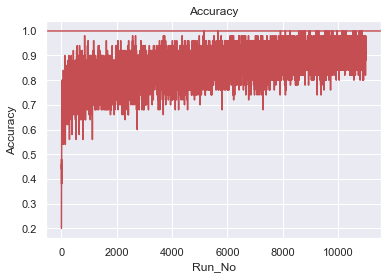

In [456]:
# Creating a plot for the accuracies of our model.
plt.plot(accuracies, 'r')
plt.title("Accuracy") 
plt.xlabel("Run_No")
plt.ylabel("Accuracy")
plt.axhline(y=max(accuracies), color='r', linestyle='-')
plt.show()

In [458]:
# Computing the predictions for our X_test data
Y_test_preds = torch.argmax(
    model(torch.tensor(X_test_vect_np).float()), dim=1).numpy()

test_accuracy = (y_test_vect_np == Y_test_preds).mean()
print(test_accuracy)

0.7999489231293097


As can be seen above the neural network that we made did not perform well (it was fast though). This might be due to several things such as the architecture of the layers, the activation function, etc. Generally, the best performing models on text data is RNNs, LSTMs and Transformer models (BERT and the like). 

### 2.2 - Testing

We will now test two best performing models on our test data, this would be the XGBoostClassifier and the Logistic Regression, both on TF-IDF weigheted sentences from word embeddings. 

#### Logistic Regression Test

In [478]:
# Testing the logistic regression:
lr = linear_model.LogisticRegression()

# Training:
lr.fit(X_train_vect_np, y_train_vect_np)

# Predicting:
lr_preds = lr.predict(X_test_vect_np)

# Calculating accuracy:
lr_accuracy = metrics.accuracy_score(y_test_vect_np, lr_preds)
lr_accuracy

0.7882863709883374

#### XGBoostClassifier

In [527]:
# Testing the logistic regression:
xgbc = xgb.XGBClassifier()

# Training:
xgbc.fit(X_train_vect_np, y_train_vect_np)

# Predicting:
xgbc_preds = xgbc.predict(X_test_vect_np)

# Calculating accuracy:
xgbc_accuracy = metrics.accuracy_score(y_test_vect_np, xgbc_preds)
xgbc_accuracy

[10:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.802502766663829

In [530]:
# Creating confusion matrices
cm_lr =metrics.confusion_matrix(y_test_vect_np,lr_preds)
cm_xgb = metrics.confusion_matrix(y_test_vect_np, xgbc_preds)

In [549]:
domain_map = {0:'Computer Science',
            1:'ECE',
            2:'Psychology',
            3:'MAE',
            4:'Civil',
            5:'Medical',
            6:'Biochemistry'}

<AxesSubplot:title={'center':'Logistic Regression Preds v True'}>

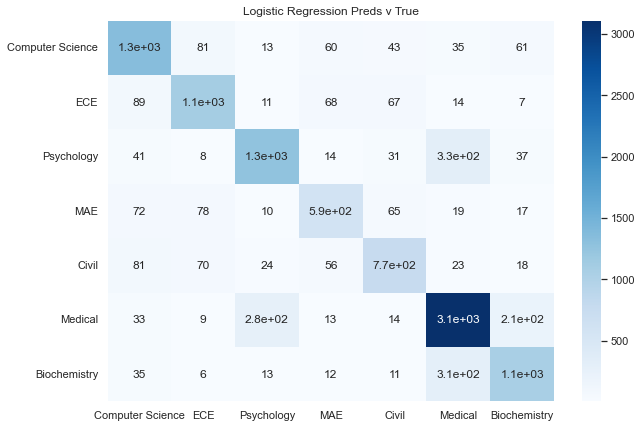

In [553]:
# Plotting the Logistic Regression confusion matrix as heatmap
df_cm_lr = pd.DataFrame(cm_lr)
df_cm_lr = df_cm_lr.rename(columns=domain_map, index=domain_map)

plt.figure(figsize = (10,7))
plt.title('Logistic Regression Preds v True')
sns.heatmap(df_cm_lr, annot=True, cmap='Blues')

<AxesSubplot:title={'center':'XGBoost Classifier Preds v True'}>

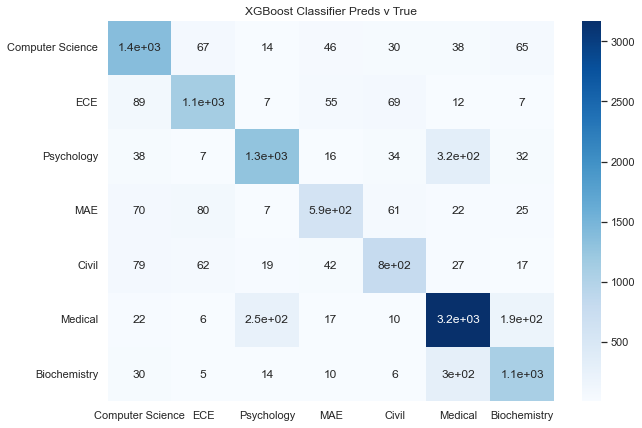

In [555]:
# Plotting the Logistic Regression confusion matrix as heatmap
df_cm_xgb = pd.DataFrame(cm_xgb)
df_cm_xgb = df_cm_xgb.rename(columns=domain_map, index=domain_map)

plt.figure(figsize = (10,7))
plt.title('XGBoost Classifier Preds v True')
sns.heatmap(df_cm_xgb, annot=True, cmap='Blues')

## 3 - Semantic Search

The TF-IDF weighted sentence vectors we have defined above using our self-trained word embeddings can also be used to do semantic search. Semantic search is a search based on meaning (semantics is the philosophical study of meaning). As meaning should be captured in our word embeddings as they are trained that way, we might be able to use the sentence vectors that we've created to search for papers given a text string. Let's try to see what this yields.

We use cosine similarity to conduct the search.

In [491]:
tfidf = TfidfVectorizer(vocabulary=embedding_dict.wv.key_to_index.keys(),
                        tokenizer=dummy_fun,
                        preprocessor=dummy_fun,
                        token_pattern=None) 

tfidf.fit(df_clean['abstract'])

TfidfVectorizer(preprocessor=<function dummy_fun at 0x000001BF3C24DCA0>,
                token_pattern=None,
                tokenizer=<function dummy_fun at 0x000001BF3C24DCA0>,
                vocabulary=dict_keys(['study', 'patients', 'results', 'using', 'data', 'used', 'system', 'also', 'model', 'c', 'analysis', 'control', 'paper', 'treatment', 'use', 'based', 'may', 'methods', 'associated', 'different', 'two', 'method',...ightsenhanced', 'incomparable', 'equivariant', 'demographicallymatched', 'multiuse', 'selfphase', 'encoders', 'licensure', 'salinas', '00015', '0186', 'appxps1', 'neurodl', 'lfs', 'lifeworld', 'preexistent', 'dissociality', 'perceptiveintuitive', 'cognitivecomputational', 'ile', 'earlyinformed', 'bandtoband', 'cichlid', 'karl', 'nonethnic', 'nonprimary', 'nonjudgemental']))

In [496]:
def get_tfidf_vector(w2v_model, search):
    search = clean_func(search, root=None)
    search = word_tokenize(search)
    if len(search) >= 1:
      words = tfidf.transform([search])
      return words @ w2v_model.wv.vectors
    else:
        return []

We now have the functionality we need to conduct a search using cosine similarity.

First we will search for: "Natural language processing neural networks"

In [499]:
search = get_tfidf_vector(embedding_dict, 'Natural language processing neural networks')
sims = cosine_similarity(search.reshape(1,300), df_vect)
ix = np.flip(np.argsort(sims)).tolist()[0][:10]
df['keywords'][ix]

45719    [attitudes,  automatic,  implicit processes,  ...
40658    [Z-transform artificial neuron (ZTAN),  Z-tran...
33645                [intelligent system,  neural network]
31539    [Autoencoder,  Convolutional neural network,  ...
22754    [Computer vision,  convolutional nets,  deep l...
38246    [deep learning,  machine learning,  molecular ...
36206    [Body perception,  Theory of mind,  Functional...
10231    [hierarchy,  representation,  natural scenes, ...
38506    [Neural divisor,  Dendrite length reduction,  ...
19685    [Computer Vision,  Natural Language Processing...
Name: keywords, dtype: object

In [502]:
search = get_tfidf_vector(embedding_dict, 'Kolmogorov Complexity')
sims = cosine_similarity(search.reshape(1,300), df_vect)
ix = np.flip(np.argsort(sims)).tolist()[0][:10]
df['keywords'][ix]

21419    [Algebraic cryptanalysis,  Multiplicative comp...
13115    [Algorithm complexity,  Incremental computatio...
42957    [System identification,  Switched linear syste...
21234    [distributed computing,  linear matrix inequal...
13140    [Manual assembly,  Assembly ergonomics,  Assem...
18774    [Gaussian assumption,  Gaussian message passin...
17827    [Dynamic programming,  Economic lot-sizing,  A...
34913    [Communication complexity,  Information theory...
18106    [Cryptography,  Spectral immunity,  Algebraic ...
44229    [Ultra dense networks,  clustering algorithms,...
Name: keywords, dtype: object

In [503]:
search = get_tfidf_vector(embedding_dict, 'Deep Learning for Stock price prediction')
sims = cosine_similarity(search.reshape(1,300), df_vect)
ix = np.flip(np.argsort(sims)).tolist()[0][:10]
df['keywords'][ix]

37302    [Financial crisis,  Bank failure,  Bagging,  H...
23196    [Cooperative coevolution,  Neuro-evolution,  F...
12016    [Deep learning,  Supervised and unsupervised a...
35628    [Learning process assessment model,  ISO/IEC 3...
44837    [Visual data classification,  Mahalanobis dist...
30092    [deep learning,  intrusion detection,  network...
17254    [Finance,  Deep learning,  Gradient-boosting, ...
31590    [Network security situation prediction,  Grey ...
44148    [Data mining,  Student Teams-Achievement Divis...
1723     [Implicit learning,  dissipative theory,  visu...
Name: keywords, dtype: object

As can be seen we can use the semantic search algorritm we have created to search for different kinds of strings. Making this into an api for searching for the abstracts that have the highest similarity to the searched string, we can use it for effective literature search. 

This could be further improved by using pretrained word embeddings (fastText, GloVe etc.), finding the similarity function that best suits our needs, finding the best weighting scheme for the sentence vector representations. 